# 1. Feature Engineering

In [1]:
import pandas as pd
import numpy as np

## 1.1 Use only categorical and binary features

In [2]:
def PrepareData(df):    
    #categorical
    cats = pd.DataFrame()
    for col in df.columns:
        if 'cat' in col:
            cats = pd.concat([cats,pd.get_dummies(df[col],prefix=col)],axis=1)
            
    #binary        
    cols = []
    for col in df.columns:
        if 'bin' in col:
            cols.append(col)
    bins = df[cols]
    
    return np.array(pd.concat([bins,cats],axis=1))

## 1.2 Split Data

In [3]:
def FeatureEngineering(trainpath,testpath):
    train = pd.read_csv(trainpath,nrows=50000)
    test = pd.read_csv(testpath,nrows=50000)
    
    df = train.append(test)
    X = PrepareData(df)
    
    trainX = X[:len(train)]
    testX = X[len(train):]
    trainy = np.array(train['target'])
    
    return trainX, trainy, testX

# 2. Three-layer Auto Encoder Model

In [4]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout

class ThreeLayer(object):
    
    def __init__(self, hfrac=0.5, dfrac=0.2):
        self.hfrac = hfrac
        self.dfrac = dfrac
        self.model = Sequential()
    
    def fit(self,X):
        self.dim = len(X[0])
        self.hdim = int(self.hfrac*self.dim)
        
        self.model.add(Dense(self.hdim, input_dim=self.dim, activation='relu'))
        self.model.add(Dropout(self.dfrac))
        self.model.add(Dense(self.dim, activation='sigmoid')) 
        self.model.compile(loss='binary_crossentropy', optimizer='adadelta')
        
        callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0)]

        self.model.fit(X, X, 
                       epochs=100, 
                       batch_size=1000, 
                       validation_split=0.2,
                       callbacks=callbacks,
                       verbose=False)
        
    def evaluate(self, X):
        return self.model.evaluate(X,X)
    
    def log_residual(self,X):
        return pd.DataFrame(self.model.predict(X)-X).applymap(abs).apply(sum,axis=1).map(np.log1p)

Using TensorFlow backend.


# 3. Class for stacking

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

class Clf4Stack_encoder(object):
    def __init__(self, model, n_splits=5):
        self.n_splits = n_splits
        self.model = model

    def fit_predict(self, trainX, trainy, testX):

        self.train4stack = np.zeros(len(trainX))
        self.test4stack = np.zeros(len(testX))

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=44)

        for i, (train_index,test_index) in enumerate(skf.split(trainX, trainy)):
            print("=====Round {0}/{1}=====".format(i+1,self.n_splits))
            X_train, X_test = trainX[train_index], trainX[test_index]
            y_train, y_test = trainy[train_index], trainy[test_index]
            
            self.model.fit(X_train[y_train==0])
            
            y_pred = self.model.log_residual(X_test)
            self.train4stack[test_index] = y_pred
            self.test4stack += self.model.log_residual(testX)
        
        self.test4stack /= self.n_splits
            
    def output(self,train_file_name='train4stack.csv',
                    test_file_name='test4stack.csv',
                    col_name='F4stack'):

        pd.DataFrame({col_name:self.train4stack}).to_csv(train_file_name,index=False) 
        pd.DataFrame({col_name:self.test4stack}).to_csv(test_file_name,index=False)

# 4. Run

## 4.1 Prepare data

In [6]:
trainpath = "/Users/guoli/Desktop/kaggle/Porto/train.csv"
testpath = "/Users/guoli/Desktop/kaggle/Porto/test.csv"

trainX, trainy, testX = FeatureEngineering(trainpath,testpath)

## 4.2 Generate data for stacking

In [7]:
C4S = Clf4Stack_encoder(ThreeLayer(0.7))

In [8]:
C4S.fit_predict(trainX, trainy, testX)

C4S.output()

=====Round 1/5=====
=====Round 2/5=====
=====Round 3/5=====
=====Round 4/5=====
=====Round 5/5=====


# 5. Checking Results

In [9]:
tmp = pd.concat([pd.read_csv('train4stack.csv'),
                 pd.read_csv(trainpath,nrows=50000,usecols=['target'])],
                axis=1)

In [10]:
tmp.head()

,F4stack,target
0,2.087625,0
1,2.188102,0
2,2.367005,0
3,2.357485,0
4,2.018459,0


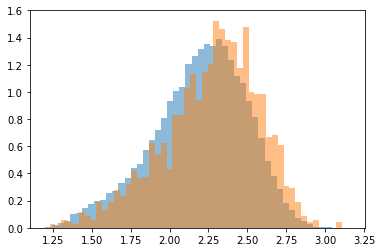

In [11]:
import matplotlib.pylab as plt

plt.hist(tmp[tmp.target==0].F4stack,bins=50,alpha=0.5,normed=True)
plt.hist(tmp[tmp.target==1].F4stack,bins=50,alpha=0.5,normed=True)
plt.show()